# VisMap

In [1]:
import os

In [2]:
# Ensure that the script is run from the repository's main directory of fdsvismap
# This is necessary because the package/module is not available for installation via pip, 
# and running it from the correct location ensures that all relative paths and dependencies work as expected.

# Check if the current working directory is the expected directory.
#print(os.getcwd())

In [1]:
from fdsvismap import VisMap

import fdsreader as fds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Processing the simulation data using fdsreader (optional)
The goal is to visualize and analyze visibility at specific timesteps within the simulation.

In [3]:
# Set path for FDS simulation directory, here Git Repo path 
sim_dir = 'examples/room_fire/fds_data'


In [5]:
# general

print(f'Version of FDSreader: {fds.__version__}')
sim = fds.Simulation(sim_dir)
print(sim)
print("-------------------------------------")

# print available slice data
for slice in sim.slices:
    print(f"Slice Type [2D/3D]: {slice.type}\n  Quantity: {slice.quantity.name}\n", 
          f" Physical Extent: {slice.extent}\n  Orientation [1/2/3]: {slice.orientation}\n")

Version of FDSreader: 1.9.11
Simulation(chid=model,
           meshes=8,
           obstructions=15,
           slices=3,
           smoke_3d=3)
-------------------------------------
Slice Type [2D/3D]: 2D
  Quantity: TEMPERATURE
  Physical Extent: Extent([0.00, 20.00] x [0.00, 10.00] x [2.10, 2.10])
  Orientation [1/2/3]: 3

Slice Type [2D/3D]: 2D
  Quantity: SOOT VISIBILITY
  Physical Extent: Extent([0.00, 20.00] x [0.00, 10.00] x [2.10, 2.10])
  Orientation [1/2/3]: 3

Slice Type [2D/3D]: 2D
  Quantity: SOOT EXTINCTION COEFFICIENT
  Physical Extent: Extent([0.00, 20.00] x [0.00, 10.00] x [2.10, 2.10])
  Orientation [1/2/3]: 3



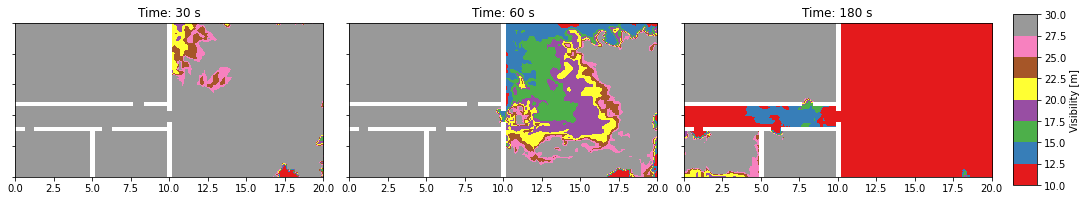

In [6]:
#fdsreader

quantity="SOOT VISIBILITY"
slc = sim.slices.filter_by_quantity(quantity).get_nearest(z=2)
slc_alldata, coordinates = slc.to_global(masked=True, fill=np.nan, return_coordinates=True)
all_x_coords = coordinates["x"]
all_y_coords = coordinates["y"]

set_times=[30, 60, 180]
time_index = slc.get_nearest_timestep(set_times[0])
data = slc_alldata[time_index]

# Truncate the colormap to use only the first 8 colors
set1 = plt.cm.get_cmap('Set1', 9)  
colors = set1(np.linspace(0, 1, 8))  
new_cmap = mcolors.ListedColormap(colors)  

# Create a figure and axes for subplots
fig, axs = plt.subplots(1, len(set_times), figsize=(15, 5), constrained_layout=True, sharey=True)

for i, (ax, time) in enumerate(zip(axs, set_times)):
    time_index = slc.get_nearest_timestep(time)
    data = slc_alldata[time_index]

    # Create the image
    img = ax.imshow(data.T, origin="lower", vmin=10, vmax=30, extent=slc.extent.as_list(), cmap=new_cmap)
    
    # Set titles for subplots
    ax.set_title(f"Time: {time} s")
    
    # Only show y-axis for the first subplot
    if i != 0:
        ax.set_yticklabels([])
        ax.set_ylabel('')

# Create a single colorbar for all subplots
cbar = fig.colorbar(img, ax=axs, orientation='vertical', pad=0.01,aspect=7, fraction=0.025)
cbar.set_ticks(np.linspace(10, 30, num=9))  # 9 ticks for 8 intervals
cbar.ax.set_yticklabels([f'{tick:.1f}' for tick in np.linspace(10, 30, num=9)])
cbar.set_label('Visibility [m]')

# Display the plot
plt.show()

# Using VisMap
Tool for waypoint-based verification of visibility in the scope of performance-based fire safety assessment

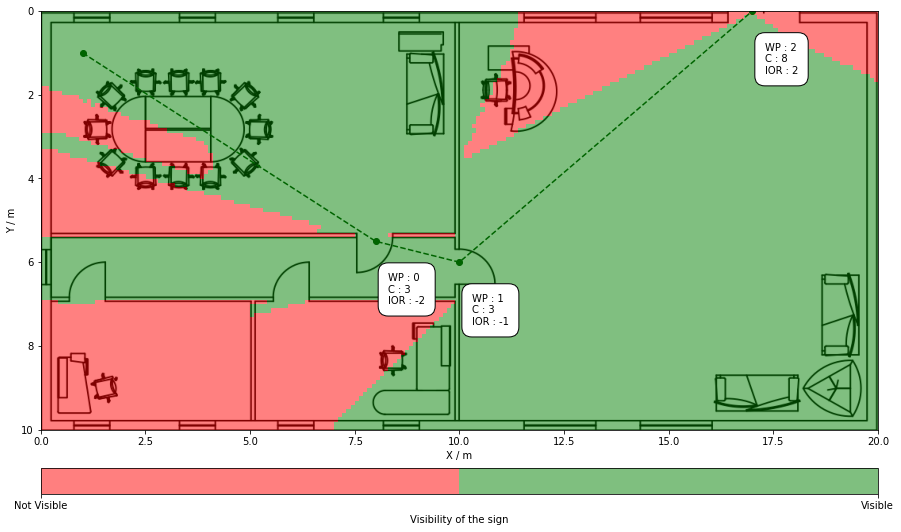

In [3]:
#VisMap, Quantity: SOOT EXTINCTION COEFFICIENT is needed in the sim

# Set path for background image directory, here Git Repo path 
bg_img = 'examples/room_fire/misc/floorplan.png'

# Create instance of VisMap class
vis = VisMap(sim_dir, min_vis=10, max_vis=30, eval_height=2, debug=False) 

# Add background image
vis.add_background_image(bg_img) 

# Set starpoint and waypoints along escape route
vis.set_start_point(1, 1) # startpoint
# waypoints shape: X,Y,C,IOR with = dimensionless constant for ligth emitting (8) and light reflecting (3) signs
vis.set_waypoint(8, 5.5, 3, -2)# waypoints 0, IOR=neg. y axis
vis.set_waypoint(10, 6, 3, -1)# waypoints 1, IOR=neg. x axis
vis.set_waypoint(17, 0, 8, 2)# waypoints 2, IOR=pos. x axis

# Define specific times for evaluating the simulation. 
# The times listed above have been chosen for demonstration purposes in this example.
vis.set_times([set_times[0], set_times[1], set_times[2]])

# Do the required calculations to create the Vismap
vis.compute_all()

# Plot time agglomerated absolute boolean vismap -bbox_pad = size of the boxes
vis.plot_time_aggl_abs_bool_vismap(size=[15,10],bbox_pad=1,fontsize=10,display_colorbar=True)